## Text Analysis with Sklearn

###  This notebook was created by Denise Gosnell: https://github.com/denisekgosnell/
#### Please reach out if you have any questions -- DeniseKGosnell@gmail.com
#### Note:  As mentioned in the demo: 
#### 1) you will have to download the data before hand 
#### 2) once downloaded, update this notebook with paths to the right directory
#### 3) I use a preprocessed version of the data where I saved *only* the last two columns of the kaggle reviews into a separate file

#### You will need to download the dataset: https://www.kaggle.com/snap/amazon-fine-food-reviews
#### You also will need to update any paths in this notebook which access the dataset

In [ ]:
# general libs
from time import time
from pprint import pprint

# data etl libs
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import pyLDAvis

# data science libs
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

output_notebook()

%matplotlib inline


## Read in the data from file

In [80]:
NUM_REVIEWS = 10000

reviews = []
t0 = time()
with open("./amazon-fine-foods/summary_only.csv", 'Ur') as read_file:
    for index, line in enumerate(read_file.readlines()):
        if index < NUM_REVIEWS:
            data = line.replace(",", " ").replace("$","").replace("!","").replace(".","").replace("\"","").split(" ")
            data_dict = {item: 1 for item in data}
            try:
                data_dict = {str(item).encode("utf8","ignore").lower(): 1 for item in data}
                reviews.append(data_dict)
            except UnicodeDecodeError:
                pass
print("File ingest done in %0.3fs." % (time() - t0))

File ingest done in 2.181s.


In [81]:
print "Total reviews: ", len(reviews)
print "First Review: \n\n", reviews[0]

Total reviews:  9981
First Review: 

{'and': 1, '': 1, 'all': 1, 'labrador': 1, 'is': 1, 'product': 1, 'looks': 1, 'have': 1, 'quality': 1, 'smells': 1, 'she': 1, 'most\n': 1, 'better': 1, 'to': 1, 'several': 1, 'more': 1, 'be': 1, 'them': 1, 'good': 1, 'food': 1, 'appreciates': 1, 'vitality': 1, 'it': 1, 'stew': 1, 'finicky': 1, 'than': 1, 'meat': 1, 'a': 1, 'canned': 1, 'like': 1, 'i': 1, 'of': 1, 'dog': 1, 'this': 1, 'products': 1, 'processed': 1, 'found': 1, 'the': 1, 'bought': 1, 'my': 1}


## Use the sklearn module to create a term x document matrix

In [82]:
dict_vectorizer = DictVectorizer(sparse=False)
t0 = time()
term_doc_mat = dict_vectorizer.fit_transform(reviews)
print("done in %0.3fs." % (time() - t0))

done in 1.271s.


### Inspect the term_doc_mat object to examine properties of the term x document matrix

In [41]:
print term_doc_mat.shape
print dict_vectorizer.get_feature_names()[18490:18500]

['labels\n', 'labels)', 'lable', 'lable<br', 'labled', 'labor-intensive', 'laboratories', 'laboratory', 'laboratory<br', 'labrador']
(9981, 33733)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
{'and': 1, 'enjoy': 1, 'all': 1, 'old': 1, 'labrador': 1, 'feel': 1, 'favorite': 1, 'yellow': 1, 'one': 1, 'as': 1, 'are': 1, 'year': 1, 'well': 1, 'really': 1, 'texture': 1, 'to': 1, 'rewarding': 1, 'treat': 1, 'size': 1, 'good': 1, "zuke's\n": 1, 'appears': 1, 'about': 1, 'natural': 1, 'treats': 1, 'these': 1, 'of': 1, "bailey's": 1, 'i': 1, 'taste': 1, 'so': 1, 'she': 1, 'the': 1, 'my': 1}


In [83]:
print term_doc_mat.shape
print term_doc_mat[0][18490:18500]
print term_doc_mat[8954][18490:18500]
print reviews[8954]

(9981, 33733)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
{'and': 1, 'enjoy': 1, 'all': 1, 'old': 1, 'labrador': 1, 'feel': 1, 'favorite': 1, 'yellow': 1, 'one': 1, 'as': 1, 'are': 1, 'year': 1, 'well': 1, 'really': 1, 'texture': 1, 'to': 1, 'rewarding': 1, 'treat': 1, 'size': 1, 'good': 1, "zuke's\n": 1, 'appears': 1, 'about': 1, 'natural': 1, 'treats': 1, 'these': 1, 'of': 1, "bailey's": 1, 'i': 1, 'taste': 1, 'so': 1, 'she': 1, 'the': 1, 'my': 1}


## Reduce the row space of the matrix to compress the data

In [44]:
def reduce_by_nmf(data, n_components):
    """
    Use non-negative matrix factorization to 
        reduce the number of columns in data to n_components
    :param data: the original term-document matrix
    :param n_components: the number of components 
        to which reduce each row of data
    :return: the reduced W matrix with dimensions 
             len(data) x n_components and the nmf model
             as a dictionary {"model": nmf_model, "w_matrix": w}
    """
    print "Starting Decomposition for {}...".format(str(n_components))
    t0 = time()
    nmf_model = NMF(init='nndsvd', n_components=n_components, max_iter=100)
    w = nmf_model.fit_transform(data)
    print("done in %0.3fs." % (time() - t0))
    return {"model": nmf_model, "w_matrix": w}

n_components=10
result_data = reduce_by_nmf(term_doc_mat, n_components)

Starting Decomposition for 10...
done in 77.746s.


## One way to view results: co-occurance matrix

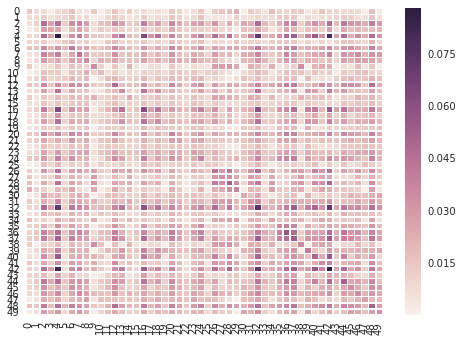

In [78]:
data = result_data["w_matrix"]
co_occurance_matrix = np.dot(data[250:300], data[250:300].transpose())
co_occurance_df = pd.DataFrame(data=co_occurance_matrix[0:,0:])
sns.set()
sns.heatmap(co_occurance_df, linewidths=.0001)

## Another way to view results: k-means cluster assignment

In [84]:
N = 10

# random color generator because
x = np.random.random(size=N+1) * 100
y = np.random.random(size=N+1) * 100
colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]

# assign cluster assignments according to N
sample = KMeans(n_clusters=N).fit_predict(result_data["w_matrix"])

# get the x, y values for the visualization
reduced_data = PCA(n_components=2).fit_transform(result_data["w_matrix"])
x = [data[0] for data in reduced_data]
y = [data[1] for data in reduced_data]

color = [colors[score] for score in sample]
p = figure()
p.circle(x, y, color=color)
show(p)

/Users/dkg/.virtualenvs/myEnv/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/dkg/.virtualenvs/myEnv/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/dkg/.virtualenvs/myEnv/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/dkg/.virtualenvs/myEnv/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/dkg/.virtualenvs/myEnv/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  de

## LDA Viz

### The first time we read in the data, we used the dict vectorizer. This time, we want a different data format

In [85]:
reviews = []
t0 = time()
NUM_REVIEWS = 10000
with open("./amazon-fine-foods/summary_only.csv", 'Ur') as read_file:
    for index, line in enumerate(read_file.readlines()):
        if index < NUM_REVIEWS:
            data = line.replace(",", " ").replace("$","").replace("!","").replace(".","").replace("\"","")
            try:
                reviews.append(str(data).encode("utf8","ignore").lower())
            except UnicodeDecodeError:
                pass
print("File ingest done in %0.3fs." % (time() - t0))
print "Total reviews: ", len(reviews)
print "First Review: \n\n", reviews[0]


norm = lambda data: pd.DataFrame(data).div(data.sum(1),axis=0).values
docs = pd.Series(reviews)

# create term x document matrix
vect = CountVectorizer(max_df=0.95, 
                       min_df=2, 
                       max_features=1000,
                       stop_words='english')
vected = vect.fit_transform(docs)

# Perform LDA
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
doc_topic_dists = norm(lda.fit_transform(vected))

prepared = pyLDAvis.prepare(
                    doc_lengths = docs.str.len(),
                    vocab = vect.get_feature_names(),
                    term_frequency = vected.sum(axis=0).tolist()[0],
                    topic_term_dists = norm(lda.components_),
                    doc_topic_dists = doc_topic_dists)
pyLDAvis.display(prepared)

File ingest done in 1.267s.
Total reviews:  9981
First Review: 

good quality dog food i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most



## Topic models for only the most reviewed items

In [86]:
most_popular = ["B007JFMH8M",
"B0026RQTGE",
"B002QWHJOU",
"B002QWP89S",
"B002QWP8H0",
"B003B3OOPA",
"B001EO5Q64",
"B000VK8AVK",
"B0013NUGDE",
"B001RVFEP2",
"B001RVFERK",
"B0026KNQSA",
"B0026KPDG8",
"B006HYLW32",
"B007M832YY",
"B007M83302",
"B000KV61FC",
"B000KV7ZGQ",
"B000NMJWZO",
"B000UBD88A",
"B0013A0QXC",
"B005K4Q1YA",
"B005K4Q34S",
"B005K4Q37A",
"B005K4Q4LK",
"B003GTR8IO",
"B0090X8IPM",
"B005ZBZLT4",
"B007Y59HVM"]
reviews = []
t0 = time()
with open("./amazon-fine-foods/Reviews.csv", 'Ur') as read_file:
    for index, line in enumerate(read_file.readlines()):
        data = line.replace(",", " ").replace("$","").replace("!","").replace(".","").replace("\"","").split()
        if data[1] in most_popular:
            try:
                data = line.replace(",", " ").replace("$","").replace("!","").replace(".","").replace("\"","")
                reviews.append(str(data).encode("utf8","ignore").lower())
            except UnicodeDecodeError:
                pass
print("File ingest done in %0.3fs." % (time() - t0))
print "Total reviews: ", len(reviews)
print "First Review: \n\n", reviews[0]


norm = lambda data: pd.DataFrame(data).div(data.sum(1),axis=0).values
docs = pd.Series(reviews)

# create term x document matrix
vect = CountVectorizer(max_df=0.95, 
                       min_df=2, 
                       max_features=1000,
                       stop_words='english')
vected = vect.fit_transform(docs)

# Perform LDA
lda = LatentDirichletAllocation(n_topics=29, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
doc_topic_dists = norm(lda.fit_transform(vected))

prepared = pyLDAvis.prepare(
                    doc_lengths = docs.str.len(),
                    vocab = vect.get_feature_names(),
                    term_frequency = vected.sum(axis=0).tolist()[0],
                    topic_term_dists = norm(lda.components_),
                    doc_topic_dists = doc_topic_dists)
pyLDAvis.display(prepared)

File ingest done in 5.886s.
Total reviews:  16664
First Review: 

20983 b002qwp89s a21u4dr8m6i9qn k m merrill justine 1 1 5 1318896000 addictive but works for night coughing in dogs my 12 year old sheltie has chronic brochotitis  been on meds for three years  these help with the coughing fits at night so i like them<br /> one bite and both my dogs are addicted be warned 7 pm both shelties are on my lap howling for the drug fix i am a dog trainer and have never seen  anything like it<br /><br />three weeks later   the beloved sheltie got a bowel blockage from these  use with caution<br />if the cat gets too many she has the runs<br />sheltie did better when i upped her thryoid meds  and gave her doggie asthma meds<br />so it worked better for the 18 year old cat  who also has asthma

